In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import networkx as nx
import scipy as sp
from sklearn.cluster import KMeans
from scipy.spatial import distance_matrix
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score
import os

FILE = "PGE.csv"
DIRI = "data"
MIN_K = 4
MAX_K = 25 # Assigned because of practicality

file_path = os.path.join(DIRI, FILE)
df = pd.read_csv(file_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43848 entries, 0 to 43847
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   date_time             43848 non-null  object
 1   raw demand (MW)       43848 non-null  object
 2   category              43848 non-null  object
 3   cleaned demand (MW)   43848 non-null  int64 
 4   forecast demand (MW)  43848 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [22]:
df["date_time"] = pd.to_datetime(df['date_time'], format='%Y-%m-%d %H:%M:%S')
df["date"] = df["date_time"].dt.date
df["hour"] = df["date_time"].dt.hour
df = df.drop(["raw demand (MW)", "category", "forecast demand (MW)", "date_time"], axis=1)
df_demand = df.pivot(index = "date", columns = "hour", values = "cleaned demand (MW)")
df_demand

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
date,,,,,,,,,,,,,,,,,,,,,
2015-07-02,2740,3287,3264,3192,3136,2974,2773,2515,2271,2121,...,2232,2421,2602,2763,2900,3026,3161,3191,3306,3363
2015-07-03,3445,3443,3410,3308,3225,3072,2807,2567,2329,2137,...,2038,2196,2349,2509,2650,2797,2892,2935,3024,3116
2015-07-04,3177,3169,3223,3093,3040,2926,2748,2485,2254,2080,...,1903,1996,2136,2276,2414,2568,2669,2720,2795,2853
2015-07-05,2852,2901,2870,2780,2690,2589,2473,2275,2127,1971,...,1780,1877,2041,2115,2320,2407,2510,2642,2702,2769
2015-07-06,2832,2880,2942,2842,2850,2702,2527,2301,2073,1933,...,2099,2247,2392,2598,2712,2839,2950,3026,3145,3158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-27,3145,3190,3111,2959,2790,2673,2491,2274,2061,1909,...,1763,1865,1978,2091,2145,2196,2221,2230,2227,2216
2020-06-28,2244,2282,2257,2200,2144,2122,2028,1879,1737,1662,...,1618,1703,1835,1946,2033,2077,2113,2129,2118,2105
2020-06-29,2152,2220,2250,2224,2184,2153,2035,1868,1737,1650,...,1914,2070,2175,2241,2297,2329,2358,2358,2376,2399


### Create Distance Matrix
Q n x n matrix that containts the distance between each point. The rows will represent "from" and the columns will represent "to" for our MST, but this is arbitrary. 

In [23]:
def create_dist_matrix(X):
   return  pd.DataFrame(distance_matrix(X.values, X.values), index=X.index, columns=X.index)

In [24]:
weights = create_dist_matrix(df_demand)
weights

date,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,...,2020-06-22,2020-06-23,2020-06-24,2020-06-25,2020-06-26,2020-06-27,2020-06-28,2020-06-29,2020-06-30,2020-07-01
date,,,,,,,,,,,,,,,,,,,,,
2015-07-02,0.000000,1096.606128,1579.513216,2143.678147,1069.718187,712.479473,1003.015454,1086.496203,1576.237609,2647.916162,...,2994.294408,1116.297003,1459.224452,2150.029302,1429.300528,2801.238655,4014.370063,3411.455701,2974.383802,3233.185890
2015-07-03,1096.606128,0.000000,910.528967,1802.041342,1329.834576,715.523585,588.364683,826.124083,1334.074211,2358.349211,...,3035.397173,1318.533276,625.324716,1887.796864,1282.886199,2167.792656,3825.561920,3422.384987,2872.373931,3160.873297
2015-07-04,1579.513216,910.528967,0.000000,973.412554,1194.120178,1142.844259,911.469144,730.501198,854.013466,1533.051206,...,2329.560259,1142.082747,705.163811,1164.060995,765.122212,1362.910122,2984.441489,2688.268216,2125.156700,2411.896557
2015-07-05,2143.678147,1802.041342,973.412554,0.000000,1316.503323,1733.767285,1565.831409,1213.704247,909.773049,714.767095,...,1459.535885,1258.058425,1575.110155,597.196785,788.627922,1075.881964,2071.714025,1808.463436,1290.950425,1554.933118
2015-07-06,1069.718187,1329.834576,1194.120178,1316.503323,0.000000,794.754050,913.420495,629.422751,862.912510,1767.913177,...,1998.782630,324.160454,1450.254805,1292.563732,634.019716,2152.775650,3052.781355,2436.366762,2021.947576,2271.664148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-27,2801.238655,2167.792656,1362.910122,1075.881964,2152.775650,2338.943137,2036.597653,1827.963895,1427.285185,1003.880471,...,2034.905157,2134.941451,1702.198578,1090.175215,1591.506833,0.000000,2116.657507,2172.885179,1590.708961,1826.459143
2020-06-28,4014.370063,3825.561920,2984.441489,2071.714025,3052.781355,3662.407405,3503.073936,3155.696278,2637.178037,1498.588336,...,1254.823494,3052.370554,3493.477494,2020.014109,2685.147110,2116.657507,0.000000,932.467158,1140.766409,948.479836
2020-06-29,3411.455701,3422.384987,2688.268216,1808.463436,2436.366762,3116.109273,3023.627623,2664.454165,2154.157608,1289.693762,...,517.102504,2476.094304,3149.082724,1625.196603,2205.282295,2172.885179,932.467158,0.000000,630.399080,381.708004


In [25]:
mst = sp.sparse.csgraph.minimum_spanning_tree(weights)
mst_arr = mst.toarray().astype(int)
mst_arr

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [26]:
np.amax(mst_arr)

769

In [27]:
mst_arr.sum()

387452


k =  4 
Sizes =  [1822    3    1    1] 
Silhouetten Score =  -0.09061573683487696 
Davies-Bouldin Score =  0.7025423485621383

k =  5 
Sizes =  [1821    3    1    1    1] 
Silhouetten Score =  -0.10654304990456959 
Davies-Bouldin Score =  0.6230609940980892

k =  6 
Sizes =  [1820    3    1    1    1    1] 
Silhouetten Score =  -0.1841929440318127 
Davies-Bouldin Score =  0.6181077715969933

k =  7 
Sizes =  [1819    3    1    1    1    1    1] 
Silhouetten Score =  -0.19066405033389558 
Davies-Bouldin Score =  0.5803049518527175

k =  8 
Sizes =  [1816    3    3    1    1    1    1    1] 
Silhouetten Score =  -0.1881497205556789 
Davies-Bouldin Score =  0.5763121989860313

k =  9 
Sizes =  [1815    3    3    1    1    1    1    1    1] 
Silhouetten Score =  -0.26860653465319917 
Davies-Bouldin Score =  0.5924926956542698

k =  10 
Sizes =  [1814    3    3    1    1    1    1    1    1    1] 
Silhouetten Score =  -0.3539823617426867 
Davies-Bouldin Score =  0.7131885993262757

k =  11

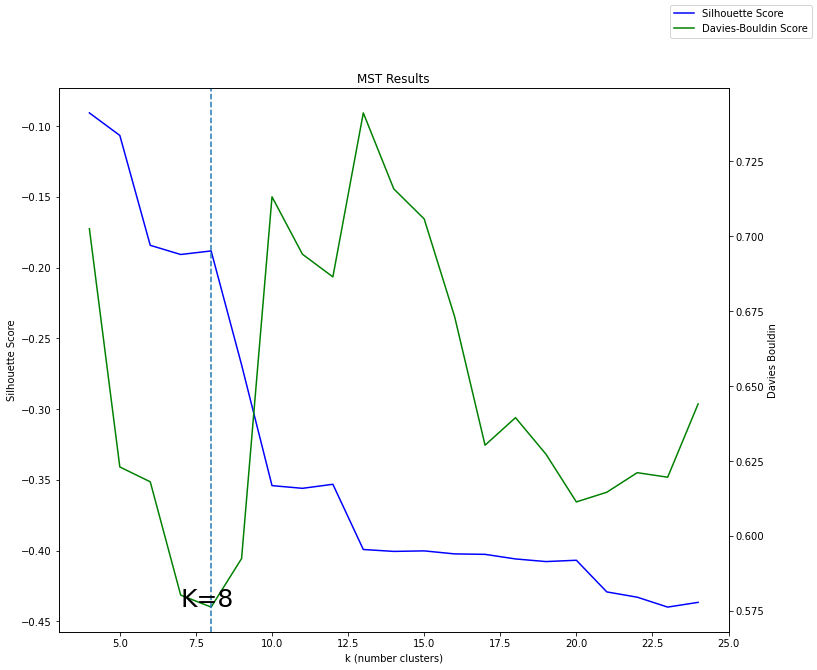

In [28]:
from numpy import unravel_index

cluster_stats = pd.DataFrame(index=range(MIN_K, MAX_K), columns=["Silhouette", "DB"])

for k in cluster_stats.index:

    temp_mst = mst_arr.copy()

    # remove k-1 largest weights to create clusters
    for i in range(k-1):
        x, y = unravel_index(temp_mst.argmax(), temp_mst.shape)
        temp_mst[x][y] = 0  

    # finds portions of graphs that are still connected, labels each group
    num_graphs, labels = sp.sparse.csgraph.connected_components(temp_mst, directed=False)

    # Need to be able to get the actual dates from the MST 
    temp_series = pd.Series(data = labels,
     index = pd.date_range('2015-07-02', '2020-07-01', freq='d'))
    
    # For each cluster label, find how many examples are part of that cluster
    cluster_sizes = temp_series.value_counts()

    # Calculate the average Silhouette Score for each cluster
    cluster_stats['Silhouette'][k] = silhouette_score(df_demand, temp_series)

    # Davies Bouldin
    cluster_stats['DB'][k] = davies_bouldin_score(df_demand, temp_series)

    print("\nk = ", k,
     "\nSizes = ", cluster_sizes.values, 
     "\nSilhouetten Score = ", cluster_stats['Silhouette'][k], 
     "\nDavies-Bouldin Score = ", cluster_stats['DB'][k])


fig, ax = plt.subplots(figsize=(12, 10))

ax.set_title("MST Results")
ax.plot(cluster_stats['Silhouette'], color='blue', label='Silhouette Score')
ax.set_xlabel("k (number clusters)")
ax.set_ylabel("Silhouette Score")

ax2 = ax.twinx()
ax2.plot(cluster_stats['DB'], color='green', label='Davies-Bouldin Score')
ax2.set_ylabel('Davies Bouldin')

ax2.axvline(x=MIN_K+np.argmin(cluster_stats['DB']), linestyle='--')
ax2.text(MIN_K+np.argmin(cluster_stats['DB'])-1,
 np.min(cluster_stats['DB']),
 f"K={MIN_K+np.argmin(cluster_stats['DB'])}", 
 fontsize=25)

fig.legend()
fig.savefig("silhouette_graphs/mst_results")

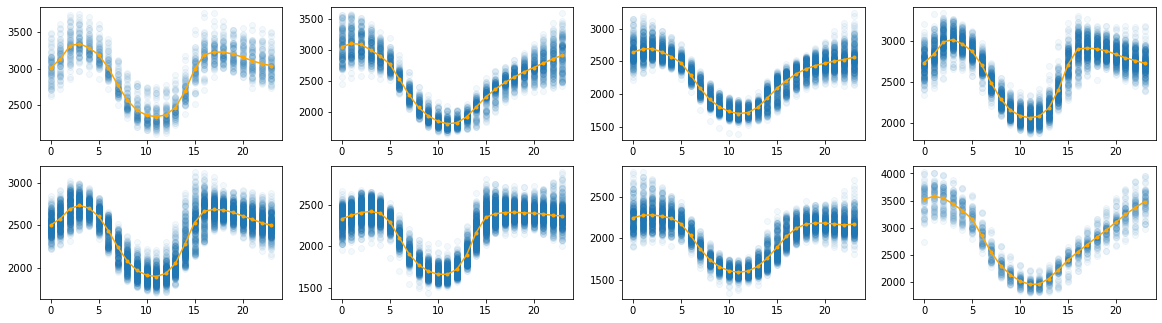

In [29]:
from matplotlib.gridspec import GridSpec

chosen_k = 8

fig = plt.figure(figsize=(20, 20))
gs = GridSpec(MAX_K//4 + 1, 4, figure=fig)

kmeans = KMeans(n_clusters=chosen_k, random_state=0).fit(df_demand)
clusters = kmeans.labels_
df_demand["profile_cluster"] = clusters

centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids = centroids.T

for k in range(chosen_k):
    df_cluster_loads = df_demand.loc[df_demand["profile_cluster"] == k].reset_index()
    df_cluster_loads.drop("profile_cluster", axis=1, inplace=True)
    df_cluster_loads = df_cluster_loads.melt(id_vars="date")
    ax = fig.add_subplot(gs[k])
    ax.scatter(df_cluster_loads["hour"], df_cluster_loads["value"], alpha=0.05)
    ax.plot(centroids[k][0:24], '.-', color='orange')

fig.savefig(f'silhouette_graphs/mst_{chosen_k}_load_profiles')